# Unsupervised initialization implementation
In this notebook the unsupervised implementation proposed in "Learning relevant features of data using multi-scale tensor networks" is implemented

In [1]:
from functools import partial
from multiprocessing import Pool
import quimb
import quimb.tensor as qtn
import torch
import torchvision as tv
from torchviz import make_dot
from torchinfo import summary
from utils import *
from ttn import *
from algebra import sep_contract, sep_partial_dm, partial_dm
from tqdm.autonotebook import tqdm, trange
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

/media/alberto/Volume/Kubuntu/PoD/Thesis/TN4HEP/TTN/utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Define dataset and model

In [2]:
root_dir = '../'
h = 8
BATCH_SIZE = 64
NUM_WORKERS = 8
DEVICE = 'cpu'
selected_labels = [0, 1]

mnist_test  = tv.datasets.MNIST(root_dir + 'data', download=True, train=False, transform=get_ttn_transform(h))
mnist_train = tv.datasets.MNIST(root_dir + 'data', download=True, train=True, transform=get_ttn_transform(h, device=DEVICE))
mnist_train_visual = tv.datasets.MNIST(root_dir + 'data', download=True, train=True, transform=get_ttn_transform_visual(h))

balanced_train, balanced_test = balance(selected_labels, mnist_train, mnist_test)

test_dl = torch.utils.data.DataLoader(balanced_test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
train_dl = torch.utils.data.DataLoader(balanced_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=(DEVICE != 'cuda'), num_workers=NUM_WORKERS)
train_visual = torch.utils.data.DataLoader(mnist_train_visual, batch_size=BATCH_SIZE)

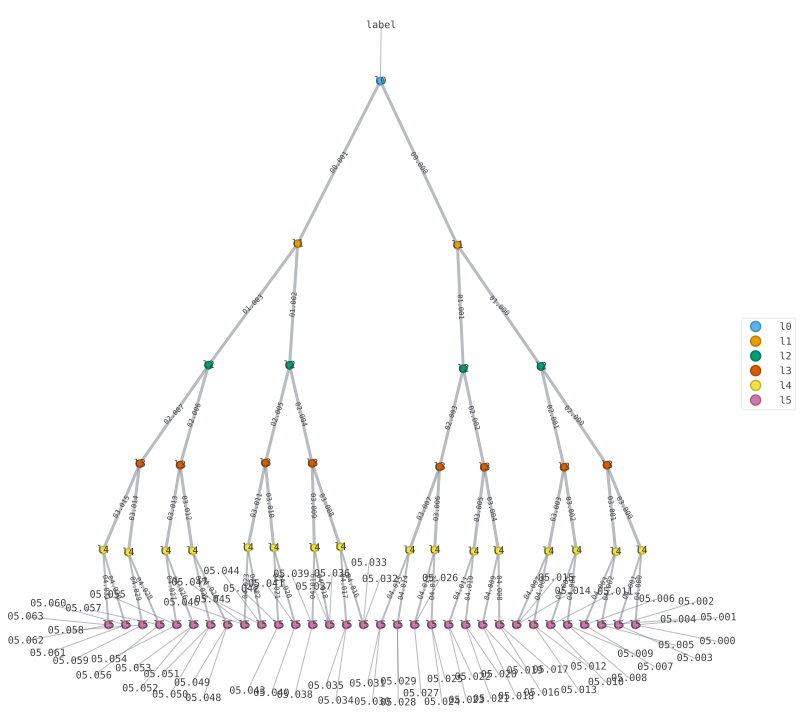

Layer (type:depth-idx)                   Output Shape              Param #
TNModel                                  [64, 2]                   9,856
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.13
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.13

In [44]:
MyTTN = TTN(h**2, n_labels=2, bond_dim=8, device='cuda')
model = TNModel(MyTTN)
model.draw()
summary(model, input_size=next(iter(train_dl))[0].squeeze().shape, dtypes=[torch.complex128])

## Let's see how to initialize...
Remember that the initialization is done at TTN class level, not in the pytorch model.
if u have problems try with deepcopy

### Tests

In [5]:
test = sep_partial_dm([15, 16], test_dl, skip_norm=True,device='cuda')
test_quimb = partial_dm([15,16], test_dl, device='cpu')
torch.allclose(torch.mean(test, dim=0).to('cpu'), test_quimb.to('cpu'))

sep_partial_dm:   0%|          | 0/31 [00:00<?, ?it/s]

quimb partial dm:   0%|          | 0/31 [00:00<?, ?it/s]

True

In [5]:
batch = next(iter(train_dl))[0].squeeze()
test=torch.linalg.eigh(sep_partial_dm([15, 16], batch, skip_norm=True, device='cuda').mean(dim=0))[1] # the bottleneck is dataloading

In [6]:
test.shape

torch.Size([4, 4])

ancora non riesco a giustificare perché il bond link dovrebbe scalare come $2^l$ e non $2^{2l}$, però si vede che tanti autovalori della partial density matrix sono zero, forse c'entra qualcoa?  
come giustificazione un po' più euristica potremmo dire che per un separable state mi basta allocare $d*N$ variabili, mentre per uno stato non separabile ne servono $d^N$ con $N$ il numero di siti e $d$ dimensione locale


In [9]:
for batch in train_dl:
    batch = batch[0].squeeze().to(device='cuda', dtype=torch.complex128)
    data_quimb = [qtn.Tensor(data=site_batch, inds=['b', f'{model.myttn.n_layers-1:02}.{i:03}'], tags='data') for i, site_batch in enumerate(torch.unbind(batch, -2))]
    data_tn = qtn.TensorNetwork(data_quimb)
    break

In [10]:
target_layer = 4
new_data_layer = data_tn.copy()
for layer in range(MyTTN.n_layers-1, target_layer-1, -1):
    tensor_list = MyTTN[f'l{layer}']
    new_data_layer = sep_contract(tensor_list, new_data_layer)
new_data_layer    

TensorNetwork(tensors=16, indices=17)

### Unsupervised part

In [45]:
# now we want to run across the ttn, layer by layer
# and initialize the tensors by getting the partial dm
# of two sites of the previous layer, diagonalizing it,
# and isometrizing the rotation matrix (with n eigenvectors
# corresponding to the n=bond_dim greatest eigenvalues)
data_tn_batched = []
for batch in tqdm(train_dl, desc='preparing dataset'):
    batch = batch[0].squeeze().to(device='cuda', dtype=torch.complex128)
    data_quimb = [qtn.Tensor(data=site_batch, inds=['b', f'{model.myttn.n_layers-1:02}.{i:03}'], tags='data') for i, site_batch in enumerate(torch.unbind(batch, -2))]
    data_tn = qtn.TensorNetwork(data_quimb)
    data_tn_batched.append(data_tn)

pbar = tqdm(total=(MyTTN.n_layers-1)*len(data_tn_batched)+2*(2**(MyTTN.n_layers-1)-1), desc='ttn init', position=1, leave=True)
for layer in range(MyTTN.n_layers-1, 0, -1): # do this for all layers except the uppermost one
    pbar.set_postfix_str(f'doing layer {layer}')
    next_layer_list = []
    ttn_curr_layer = MyTTN.select_tensors(f'l{layer}')
    # perform initialization of current layer with partial dm
    # of state at previous layer
    for i, tensor in enumerate(ttn_curr_layer):
        pbar.set_postfix_str(f'doing layer {layer}, tensor {i+1}/{2**layer}')
        sel_sites = [int(index.split('.')[-1]) for index in tensor.inds[:2]]
        partial_dm = torch.concat([sep_partial_dm(sel_sites, datum_tn, skip_norm=True, device='cuda') for datum_tn in data_tn_batched]).mean(dim=0)
        eigenvectors = torch.linalg.eigh(partial_dm)[1][:, -tensor.shape[-1]:] # the physical indices of the two sites are fused in the first index, we have to reshape
        #eigenvectors_iso = 
        tensor.modify(data=eigenvectors.reshape(tensor.shape), inds=tensor.inds, tags=tensor.tags)
        tensor.isometrize(left_inds=tensor.inds[2:], method='householder', inplace=True) # this operation moves the bond link to the left, we have to move it back
        tensor.moveindex(tensor.inds[0], -1, inplace=True)

        pbar.update(1)

    # calculate next propagation of data to this layer
    # with the updated tensors
    pbar.set_postfix_str(f'doing layer {layer}, propagating data')
    for data_tn in data_tn_batched:      
        new_data_layer = sep_contract(ttn_curr_layer, data_tn)
        next_layer_list.append(new_data_layer)
        pbar.update(1)
    data_tn_batched = next_layer_list
pbar.set_postfix_str(f'done!')
pbar.close()

preparing dataset:   0%|          | 0/186 [00:00<?, ?it/s]

ttn init:   0%|          | 0/992 [00:00<?, ?it/s]

In [46]:
check_correct_init(model)

(True, 0)

### Supervised part
after the initialization of all the layers, except for the upmost one, we have to "train" this single tensor with a gradient descent; they suggest to use a conjugate gradient optimization

In [8]:
def sep_contract_torch(tensors, data_tensors):
    # perform network contraction assuming
    # each tensor in tensor_list has to be
    # contracted with two contiguous tensors
    # in data_tensors
    is_batch = data_tensors[0].ndim > 1
    if is_batch:
        contr_string = 'xyz,bx,by->bz'
    else:
        contr_string = 'xyz,x,y->z'
        
    results = []
    for i, tensor in enumerate(tensors):
        results.append(torch.einsum(contr_string, tensor, data_tensors[2*i], data_tensors[2*i+1]))

    return torch.stack(results).squeeze()

In [47]:
# recover the data representation before the top layer
# and then optimize the tensor

next_to_top_layer_data = data_tn_batched #this works as during initialization we have already propagated the data to the next to top layer
top_tensor = MyTTN.select_tensors('l0')[0]
top_tensor.data

tensor([[[-0.7556+0.9142j,  1.4770-1.1367j],
         [-0.0605-1.3163j,  0.4809-1.0998j],
         [ 0.9904+0.8936j,  0.4758-0.1687j],
         [ 0.7850+2.1220j,  1.4662+0.0308j],
         [ 1.2513+1.3791j, -0.5239-2.1241j],
         [-0.3694-0.6265j, -0.2744-1.0189j],
         [-0.0728+1.0786j,  0.0281-0.1890j],
         [ 0.9329+0.1277j,  0.1621+0.6565j]],

        [[ 0.5433-0.6046j, -0.3074+0.4750j],
         [ 0.6797-0.8987j, -0.2436-0.0313j],
         [-0.4891+0.2216j, -0.3966+2.0202j],
         [ 0.6842+0.6952j, -0.3437+0.4674j],
         [-1.2495-0.7992j,  1.4192+0.2334j],
         [ 1.5130+0.1610j, -1.6487+0.5082j],
         [-0.6724-0.9487j,  0.9739-1.0990j],
         [ 0.3236+2.1368j,  0.7800-0.7669j]],

        [[-0.1323+1.3075j,  1.1626+0.2177j],
         [-1.5753+1.0101j, -1.0346+0.8728j],
         [-1.5033-0.4951j,  0.5853-1.3413j],
         [-0.1673-0.1987j, -1.3206-1.7848j],
         [-0.0076+0.2859j,  0.5106-0.7507j],
         [ 0.1469+1.0737j, -1.9871-0.2381j],
      

In [48]:
def loss(labels, output):
    #labels[labels!=1] = 0
    return torch.sum(torch.sum((output - torch.nn.functional.one_hot(labels))**2, 1))/2

In [73]:
def one_epoch_one_tensor(tensor, data_tn_batched, train_dl, optimizer, loss_fn, device='cuda'):
    # perform one epoch of optimization of a single tensor
    # given the data_tn and the optimizer
    tot_data = 0
    lossess = []
    pbar = tqdm(data_tn_batched, total=len(data_tn_batched),position=0)
    with torch.autograd.set_detect_anomaly(True):
        for data_tn, batch in zip(data_tn_batched, train_dl):
            optimizer.zero_grad()
            labels = batch[1].to(device=device)
            data = torch.stack([tensor.data for tensor in data_tn['l1']])
            outputs = sep_contract_torch([tensor], data)
            
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            loss = loss_fn(labels, probs)

            loss.backward()
            optimizer.step()
            lossess.append(loss.cpu())
            tot_data += labels.shape[0]
            pbar.update()
            pbar.set_postfix_str(f'loss: {loss.item():.3f}')
    
    pbar.set_postfix({'loss': loss.item(), 'epoch mean loss': np.array([loss.item() for loss in lossess]).sum() / tot_data})
    pbar.close()
    return lossess

In [74]:
LR = 1e-1
EPOCHS = 20

top_parameter = torch.nn.Parameter(top_tensor.data)
top_tensor = qtn.Tensor(data=top_parameter, inds=top_tensor.inds, tags=top_tensor.tags)
optimizer = torch.optim.Adam([top_parameter], lr=LR)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, .8, 18)

In [75]:
tot_losses = []
for epoch in trange(EPOCHS):
    lossess = one_epoch_one_tensor(top_parameter, next_to_top_layer_data, train_dl, optimizer, loss)
    scheduler.step()
    tot_losses += lossess

tot_losses = np.array([loss.detach() for loss in tot_losses])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

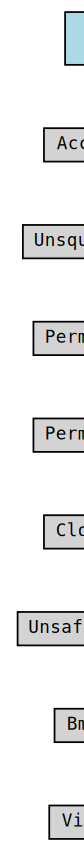

In [55]:
make_dot(lossess[0], params={'0':top_parameter})

try with real numbers !?!?R£)!|?E)!Ei2\ù

In [76]:
top_parameter

Parameter containing:
tensor([[[-0.7533+1.2421j,  1.6214-1.1257j],
         [-0.0506-1.1793j,  0.5653-1.1680j],
         [ 1.0010+0.3259j,  0.2801-0.2447j],
         [ 0.7963+1.5410j,  1.2683-0.0479j],
         [ 1.2955-0.7565j, -1.2812-2.0885j],
         [-0.3804-0.0507j, -0.0773-0.9412j],
         [-0.0499+0.3174j, -0.1908-0.2958j],
         [ 0.9421-0.4172j, -0.0298+0.5852j]],

        [[ 0.5409-0.9297j, -0.4583+0.4792j],
         [ 0.6697-1.0325j, -0.3353+0.0542j],
         [-0.4995+0.7870j, -0.1953+2.0832j],
         [ 0.6729+1.2738j, -0.1404+0.5332j],
         [-1.2937+1.3370j,  2.1750+0.2011j],
         [ 1.5239-0.4125j, -1.8512+0.4435j],
         [-0.6953-0.1896j,  1.1976-1.0036j],
         [ 0.3145+2.6792j,  0.9776-0.7089j]],

        [[-0.1300+1.6347j,  1.3089+0.2244j],
         [-1.5653+1.1462j, -0.9481+0.7995j],
         [-1.4928-1.0622j,  0.3879-1.4136j],
         [-0.1560-0.7790j, -1.5201-1.8597j],
         [ 0.0366-1.8498j, -0.2463-0.7161j],
         [ 0.1359+1.6488j, -1

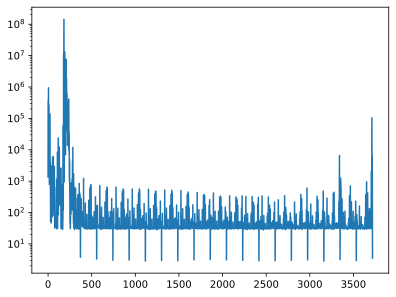

In [77]:
plt.plot(tot_losses)
#plt.ylim(20, 100)
plt.yscale('log')

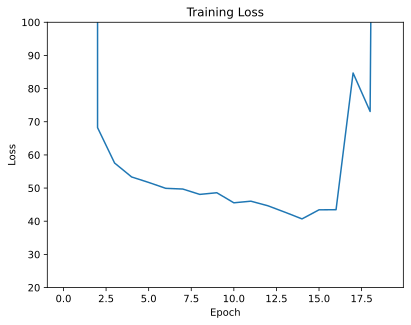

In [78]:
plt.plot([tot_losses[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])
plt.xlabel('Epoch')
plt.ylim(20, 100)
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Deprecated code

In [4]:
# adapted from original numpy code
def sparse_kron(A: torch.Tensor, B: torch.Tensor, format=torch.sparse_csr):
    
    if A.dim() < 2:
        A = A.unsqueeze(-1)
    if B.dim() < 2:    
        B = B.unsqueeze(-1)

    A = A.to_sparse_coo()
    B = B.to_sparse_coo()
    output_shape = (A.shape[0]*B.shape[0], A.shape[1]*B.shape[1])

    if A._nnz() == 0 or B._nnz() == 0:
        # kronecker product is the zero matrix
        return torch.zeros(output_shape, layout=format)

    # expand entries of a into blocks
    row, col = A.indices().repeat_interleave(B._nnz(), dim=1)
    data     = A.values().repeat_interleave(B._nnz())

    if max(A.shape[0]*B.shape[0], A.shape[1]*B.shape[1]) > torch.iinfo(torch.int32).max and row.dtype == torch.int32:
        row = row.to(torch.int64)
        col = col.to(torch.int64)

    row *= B.shape[0]
    col *= B.shape[1]

    # increment block indices
    row, col = row.reshape(-1,B._nnz()), col.reshape(-1,B._nnz())
    row += B.indices()[0]
    col += B.indices()[1]
    row, col = row.reshape(-1), col.reshape(-1)

    indices = torch.stack((row, col))

    # compute block entries
    data = data.reshape(-1,B._nnz()) * B.values()
    data = data.reshape(-1)

    return getattr(torch.sparse_coo_tensor(indices, data, size=output_shape), "to_" + str(format)[6:])()

# for batch dimension
def kron(a: torch.Tensor, b: torch.Tensor, batchs: int):

    ndb, nda = b.ndim, a.ndim
    nd = max(ndb, nda)-1 # suppose the first dimension is batch dimension

    if (nda == 0 or ndb == 0):
        return torch.multiply(a, b)

    as_ = a.shape
    bs = b.shape

    # Equalise the shapes by prepending smaller one with 1s
    as_ = (as_[0],) + (1,)*max(0, ndb-nda) + as_[1:]
    bs = (bs[0],) + (1,)*max(0, nda-ndb) + bs[1:]

    # Insert empty dimensions
    a_arr = a.view(as_) 
    b_arr = b.view(bs)
    
    # Compute the product
    for axis in range(1, nd*2, 2):
        a_arr = a_arr.unsqueeze(1+axis)
    for axis in range(0, nd*2, 2):
        b_arr = b_arr.unsqueeze(1+axis)
    
    result = torch.multiply(a_arr, b_arr)

    # Reshape back
    result = result.reshape((batchs,) + tuple(np.multiply(as_[1:], bs[1:])))

    return result

In [6]:
def trace_matrix_statek(sites_index, k, num_sites, local_dim=2):
    tr_mat = torch.eye(1).to_sparse_coo()
    for i in trange(num_sites, desc='trace_matrix', position=1):
        if i in sites_index:
            tr_mat = sparse_kron(tr_mat, torch.eye(local_dim)[k,:])
        else:
            tr_mat = sparse_kron(tr_mat, torch.eye(local_dim))
    return tr_mat

In [8]:
state_torch = torch.tensor([[1, 0], [1, 1]/np.sqrt(2), [0, 1]])
mps = qtn.MatrixProductState(state_torch.unsqueeze(1).unsqueeze(1))
mps 

/tmp/ipykernel_2703/1903958582.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state_torch = torch.tensor([[1, 0], [1, 1]/np.sqrt(2), [0, 1]])


MatrixProductState(tensors=3, indices=6, L=3, max_bond=2)

In [9]:
rho = mps.partial_trace([0, 1, 2]).to_dense()
rho=rho.reshape(2,2,2,2,2,2)

In [10]:
torch.einsum('bcabcd -> ad', rho)

tensor([[0.0000, 0.0000],
        [0.0000, 1.0000]], dtype=torch.float64)

In [21]:
mps.partial_trace([0, 1]).to_dense()

tensor([[0.5000, 0.5000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)

In [12]:
partial_dm([0], [[[torch.tensor([[1, 0], [1, 0], [0, 1]])], [0]], ], device='cpu')

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], dtype=torch.complex128)

In [13]:
def sep_partial_dm(keep_index, sep_states: torch.utils.data.DataLoader | torch.Tensor, skip_norm=False, device='cpu'):
    keep_index = torch.tensor(keep_index, device=device, dtype=torch.int64)
    if isinstance(sep_states, torch.utils.data.DataLoader):
        discard_index = torch.ones(next(iter(sep_states))[0].shape[-2], dtype=torch.bool)
        discard_index[keep_index] = False
        rho_list = []
        for batch in tqdm(sep_states, desc='sep_partial_dm', position=1):
            batch = batch[0].squeeze().to(device)
            if skip_norm:
                norm_factor = torch.eye(1, device=device)
            else:
                norm_factor = torch.prod(torch.sum(batch[...,discard_index,:]**2, dim=-1), dim=-1).squeeze()

            rhos = torch.einsum('...i,...j->...ij', batch[...,keep_index,:].conj(), batch[...,keep_index,:])
            rho = torch.eye(1, device=device, dtype=torch.complex128)
            
            for i in keep_index-keep_index.min():   # strange way to index but in this way we can get the partial density matrix also for different permutations of the sites
                rho = kron(rho, rhos[...,i,:,:], batchs=batch.shape[0])
            
            rho_list.append(rho*norm_factor.view([-1]+[1]*(rho.ndim-norm_factor.ndim)))
        return torch.concat(rho_list, dim=0)
            
    else:
        batch = sep_states.squeeze().to(device)
        if skip_norm:
            norm_factor = torch.eye(1, device=device, dtype=torch.complex128)
        else:
            discard_index = torch.ones(sep_states.shape[-2], dtype=torch.bool)
            discard_index[keep_index] = False
            norm_factor = torch.prod(torch.sum(batch[...,discard_index,:]**2, dim=-1), dim=-1).squeeze()
        
        rhos = torch.einsum('...i,...j->...ij', batch[...,keep_index,:].conj(), batch[...,keep_index,:])
        rho = torch.eye(1, device=device)
        for i in keep_index-keep_index.min():
            rho = kron(rho, rhos[...,i,:,:], batchs=batch.shape[0])

        return rho*norm_factor.view([-1]+[1]*(rho.ndim-norm_factor.ndim))


In [32]:
batch = next(iter(train_dl))[0]

In [27]:
test.mean(dim=0)

tensor([[9.9359e-01+0.j, 2.1911e-02+0.j, 7.5882e-05+0.j, 6.6424e-05+0.j, 2.4985e-03+0.j,
         1.9331e-05+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [2.1911e-02+0.j, 6.1327e-03+0.j, 6.6424e-05+0.j, 7.7783e-05+0.j, 1.9331e-05+0.j,
         1.3483e-06+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [7.5882e-05+0.j, 6.6424e-05+0.j, 3.3950e-06+0.j, 3.7508e-06+0.j, 0.0000e+00+0.j,
         0.0000e+00+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [6.6424e-05+0.j, 7.7783e-05+0.j, 3.7508e-06+0.j, 4.7447e-06+0.j, 0.0000e+00+0.j,
         0.0000e+00+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [2.4985e-03+0.j, 1.9331e-05+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j, 2.7169e-04+0.j,
         2.1266e-06+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [1.9331e-05+0.j, 1.3483e-06+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j, 2.1266e-06+0.j,
         8.9898e-08+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j],
        [0.0000e+00+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j, 0.0000e+00+0.j,
         0.0000e+00+0.j, 0.00

In [38]:
torch.linalg.eig(test.mean(dim=0))

torch.return_types.linalg_eig(
eigenvalues=tensor([9.9973e-01+0.j, 2.6552e-04+0.j, 8.1156e-06+0.j, 0.0000e+00+0.j],
       device='cuda:0', dtype=torch.complex128),
eigenvectors=tensor([[ 1.0000e+00+0.j, -2.5010e-03+0.j, -1.5744e-04+0.j,  0.0000e+00+0.j],
        [ 1.5371e-04-0.j, -1.4931e-03+0.j,  1.0000e+00+0.j,  0.0000e+00+0.j],
        [ 2.5012e-03-0.j,  1.0000e+00+0.j,  1.4927e-03-0.j,  0.0000e+00+0.j],
        [-0.0000e+00+0.j, -0.0000e+00+0.j, -0.0000e+00+0.j,  1.0000e+00+0.j]],
       device='cuda:0', dtype=torch.complex128))